# Import Necessary Modules and Download Images from GitHub Repository

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import imread

import os
import random
import shutil

In [25]:
!rm -r KF6007---AI-Robotics/
!sudo apt-get install git-lfs
!git lfs install
!git lfs clone https://github.com/FayetalException/KF6007---AI-Robotics.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'KF6007---AI-Robotics'...
remote: Enumerating objects: 7168, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 7168 (delta 6), reused 183 (delta 3), pack-reused 6982
Receiving objects: 100% (7168/7168), 414.60 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (8795/8795), done.
Git LFS: (1 of 1 files) 206.62 MB / 206.62 MB


# Set the Train + Validation Paths and Create an Image Transformer

In [26]:
train_path = '/content/KF6007---AI-Robotics/PokemonData/Poke_Train'
val_path = '/content/KF6007---AI-Robotics/PokemonData/Poke_Val'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=20, # applies random transforms to image
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

# Show Number of Classes for Both Train and Validation

In [27]:
train_total = image_gen.flow_from_directory(train_path)
val_total = image_gen.flow_from_directory(val_path)
print(f'{train_total}\n{val_total}')

Found 6820 images belonging to 150 classes.
Found 1944 images belonging to 150 classes.


# Create the CNN Model


In [28]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

image_shape = (256,256,3) # Set the image size for consistency

# if previous model exists...
model = Sequential()
model_name="poke_model.h5"
model_exists = False

loss_name= "loss_history.csv"
loss_history = pd.DataFrame()
loss_exists = False

try: # if model file exists, load that model
  model_exists = os.path.isfile("/content/KF6007---AI-Robotics/poke_model.h5")
  model = load_model("/content/KF6007---AI-Robotics/poke_model.h5")
  print(f'Loading existing trained model - {model_exists}')

  loss_exists = os.path.isfile("/content/KF6007---AI-Robotics/loss_history.csv")
  loss_history = pd.read_csv("/content/KF6007---AI-Robotics/loss_history.csv")
  print(f'Loading existing loss history - {loss_exists}')
except Exception as e:
  print(f'{e}')

Loading existing trained model - True
Loading existing loss history - True


In [29]:
if model_exists == False:
  model.add(Conv2D(filters=64,kernel_size=(3),
                  padding='same',input_shape=image_shape,activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Conv2D(filters=128,kernel_size=(3),
                  padding='same',input_shape=image_shape,activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))

  model.add(BatchNormalization())

  model.add(Conv2D(filters=128,kernel_size=(3),
                  padding='same',input_shape=image_shape,activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  
  model.add(BatchNormalization())

  model.add(Conv2D(filters=256,kernel_size=(3),
                  padding='same',input_shape=image_shape,activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))

  model.add(Flatten())
  model.add(Dense(1024,activation='relu'))
  model.add(Dropout(rate=0.25))
  model.add(Dense(512,activation='relu'))
  model.add(Dense(150,activation='softmax'))


  model.compile(loss='categorical_crossentropy', 
                optimizer=Adam,
                metrics=['accuracy','mse'])

model.summary() # Print out a summary of the assembled model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       1

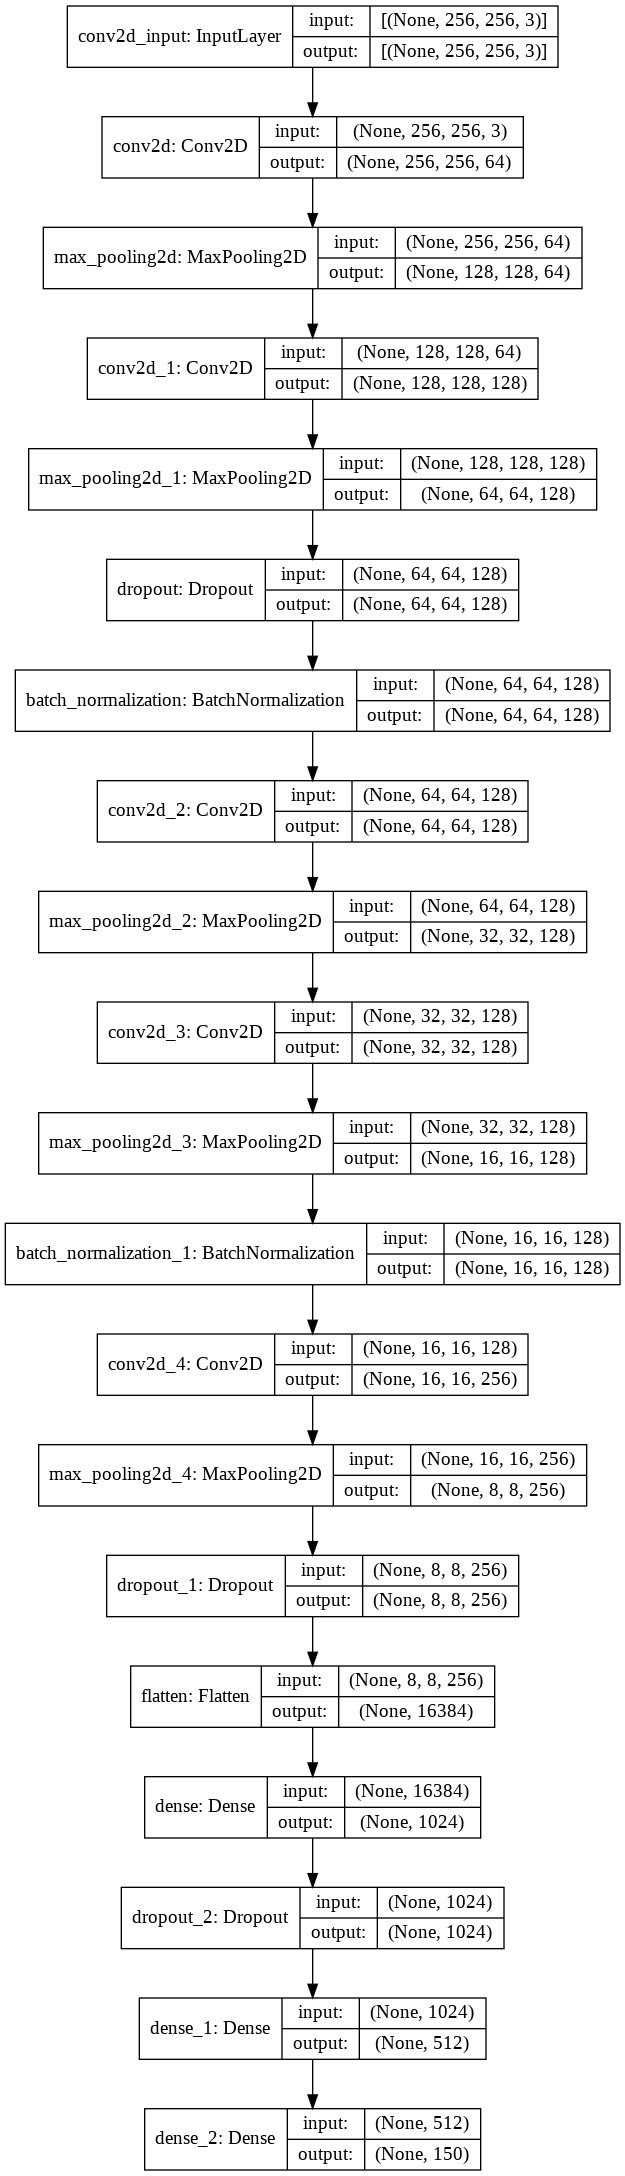

In [30]:
from keras.utils.vis_utils import plot_model
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

# Batch the Images and Create Final Image Sets

In [31]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

val_image_gen = image_gen.flow_from_directory(val_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 6820 images belonging to 150 classes.
Found 1944 images belonging to 150 classes.


# Train the Model
Includes an early stopping mechanism to stop the training early if `val_loss` does not increase for 5 epochs.

In [32]:
# Defining a callback for early stopping to utilize computing resources effeciently
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',patience=5)

if loss_exists == False or model_exists == False:
  results = model.fit(train_image_gen,
                    epochs=40,
                    callbacks=[early_stopping],
                    validation_data=val_image_gen
                    )

# Save the Model and History for Future Use
Also plot two graphs containing the accuracy and loss of the model

In [33]:
if loss_exists == False or model_exists == False:
  loss_history = pd.DataFrame(model.history.history)
  loss_history.to_csv('loss_history.csv')
  model.save('new_poke_model.h5')
model.evaluate(val_image_gen)

122/122 [==============================] - 69s 341ms/step - loss: 0.1880 - accuracy: 0.9465


[0.18797987699508667, 0.9465020298957825]

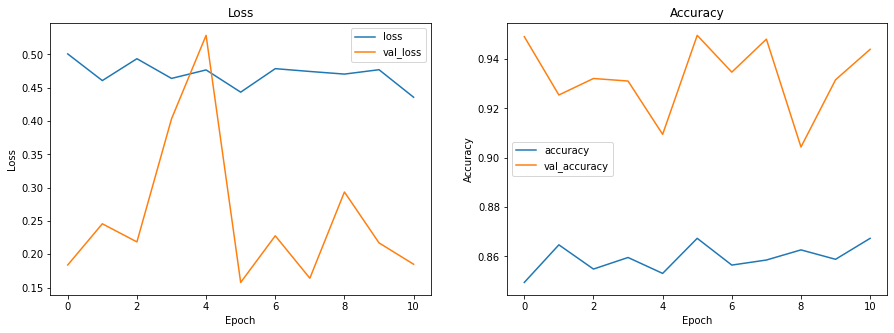

In [34]:
plt.figure(figsize=[15,5])

# plotting the loss
plt.subplot(1,2,1)
plt.plot(loss_history[['loss','val_loss']])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['loss','val_loss'])

# plotting the accuracy
plt.subplot(1,2,2)
plt.plot(loss_history[['accuracy','val_accuracy']])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['accuracy','val_accuracy'])

plt.savefig("Loss-accuracy-graphs.jpg")

# Import Modules for Obtaining Images from Internet
Create a function to gather images from internet and then apply the trained model to said images

In [35]:
# Importing standard libraries for image and web url
from tensorflow.keras.preprocessing import image
import urllib.request
from PIL import Image

def predict_pokemon(img_url):
  img_path = urllib.request.urlopen(img_url)
  
  img = Image.open(img_path)
  img = img.resize((256,256))
  
  plt.imshow(img)
  plt.axis("off")
  
  img = np.array(img)
  if img.shape[2] != 3:
      img = img[:,:,:3]

  img = img/255 # Normalise the img
  my_img_array = np.expand_dims(img,axis=0) # Add extra dimension

  # Fething the prediction
  pred_class = np.argmax(model.predict(my_img_array),axis=-1)
  poke_class = {value:key for key,value in train_image_gen.class_indices.items()}
  plt.title(poke_class[pred_class[0]])
  plt.show()
  print("\n")

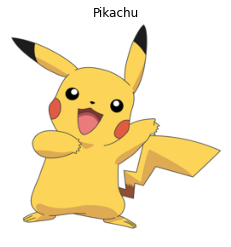

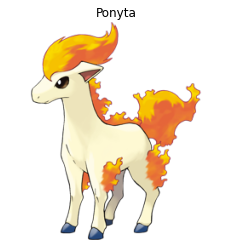

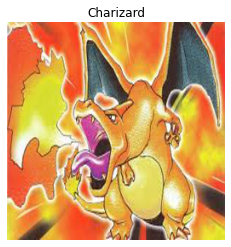

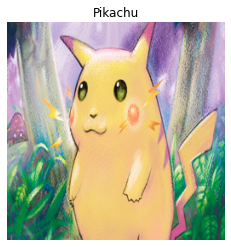

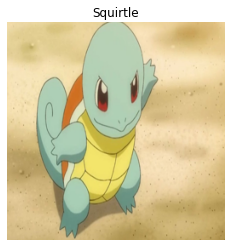

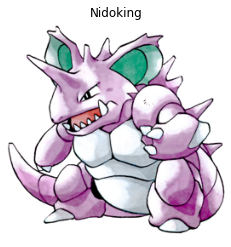



Enter image URL:



ValueError: ignored

In [36]:
img = 'https://static.wikia.nocookie.net/wii/images/8/89/Pikachu.jpg/revision/latest?cb=20140209205851.png'
img2 = 'https://static.wikia.nocookie.net/spellcasters/images/3/3b/077Ponyta.png/revision/latest?cb=20200917083400'
img3 = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRc_qu01NhZSqJL3ubmjd1uEOccB7Kte2ivOA&usqp=CAU'
img4 = 'https://assets.dicebreaker.com/pokemon-tcg-25th-anniversary-pikachu-base-set-artwork.png/BROK/thumbnail/1600x900/quality/100/pokemon-tcg-25th-anniversary-pikachu-base-set-artwork.png'
img5 = 'https://media.comicbook.com/2020/08/pokemon-squirtle-1234568.jpeg?auto=webp'
img6 = 'https://64.media.tumblr.com/c0ca04caf0a43eac79cf949d400b2ccf/tumblr_pbn9lyjyvI1vw1ceco1_1280.png'
pokemon = [img, img2, img3, img4, img5, img6]

for i in pokemon:
  predict_pokemon(i)

img = input('Enter image URL:\n')#https://bleedingcool.com/wp-content/uploads/2020/07/Base-Set-Venusaur-art-ptcg-1200x900.jpg
predict_pokemon(img)